In [4]:
import cv2
import numpy as np

def adaptive_thresholds(image, underexposed_factor=0.15, overexposed_factor=5.0):
    """
    Computes adaptive thresholds for underexposed and overexposed pixels based on the median value of each channel.

    Parameters:
    - image: Input image (numpy array).
    - underexposed_factor: Factor for determining underexposed pixel threshold (15% of median).
    - overexposed_factor: Factor for determining overexposed pixel threshold (500% of median).

    Returns:
    - lower_thresh: Adaptive lower threshold for each channel.
    - upper_thresh: Adaptive upper threshold for each channel.
    """
    lower_thresh = []
    upper_thresh = []

    # Iterate over each channel
    for i in range(image.shape[2]):
        channel = image[:, :, i]
        median_val = np.median(channel)

        lower_thresh.append(median_val * underexposed_factor)
        upper_thresh.append(median_val * overexposed_factor)
    
    return lower_thresh, upper_thresh

def detect_and_fix_dead_pixels_multispectral(image, filter_size=3, underexposed_factor=0.15, overexposed_factor=5.0):
    """
    Detects and fixes dead pixels in a multispectral image using a median filter.

    Parameters:
    - image: Input image with multiple channels (numpy array).
    - filter_size: Size of the median filter.
    - underexposed_factor: Factor for determining underexposed pixel threshold.
    - overexposed_factor: Factor for determining overexposed pixel threshold.

    Returns:
    - Fixed image (numpy array).
    """
    fixed_image = np.copy(image)
    lower_thresh, upper_thresh = adaptive_thresholds(image, underexposed_factor, overexposed_factor)

    # Apply median filter to each channel
    for i in range(image.shape[2]):
        channel = image[:, :, i]
        mask = (channel == 0) | (channel < lower_thresh[i]) | (channel > upper_thresh[i])
        median_filtered_channel = cv2.medianBlur(channel, filter_size)
        fixed_image[:, :, i][mask] = median_filtered_channel[mask]

    return fixed_image

In [5]:
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Path to your multispectral TIFF file
tiff_file = '1_20/crop_3_3_0000.tif'

# Open the TIFF file
with rasterio.open(tiff_file) as src:
    # Read the metadata
    metadata = src.meta
    print("Metadata:", metadata)
    
    # Read specific bands (e.g., bands 1, 2, and 3)
    crop = src.read().transpose(1,2,0)
    #crop2 = src.read(2)
    #crop3 = src.read(3)
    #crop4 = src.read(4)
    #fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(14,7))
    #show(src, ax=axrgb)
    #show_hist(src, bins=500, lw=0.0, stacked=False, alpha=0.3,histtype='stepfilled', title="Histogram",ax=axhist)
    #plt.legend()


Metadata: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 220, 'height': 187, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.1, 0.0, 0.0,
       0.0, 0.1, 0.0)}


In [6]:
crop.shape[2]

4

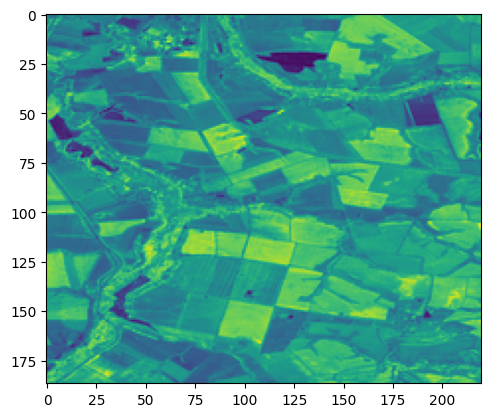

In [10]:
import matplotlib.pyplot as plt
# Example usage
    # Load an example multispectral image (with 4 channels)

    # Detect and fix dead pixels
fixed_image = detect_and_fix_dead_pixels_multispectral(crop)

    # Save the result
cv2.imwrite('fixed_multispectral_image.tif', fixed_image)

    # Display the original and fixed images for each channel
for i in range(crop.shape[2]):
    plt.imshow(crop[:, :, i])
    plt.imshow(fixed_image[:, :, i])


In [19]:
def find_difference(original_image,fixed_image):
# Find the indices where the images differ
    differences = np.where(original_image != fixed_image)

    # Unpack the indices into row, column, and channel arrays
    rows, cols, channels = differences

    # Create a list to store the report lines
    report_lines = []

    # Iterate over the indices of the differing pixels
    for i in range(len(rows)):
        row = rows[i]
        col = cols[i]
        channel = channels[i]
        original_value = original_image[row, col, channel]
        fixed_value = fixed_image[row, col, channel]

        # Append the report line to the list
        report_lines.append(f"{row}; {col}; {channel + 1}; {original_value}; {fixed_value}")

    # Join the report lines into a single string
    report_string = "\n".join(report_lines)

    # Create a JSON object with a single field "report"
    report_json = {"report": report_string}
    return report_json
